In [53]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from lifelines import KaplanMeierFitter, statistics

In [54]:
DATA_DIR = Path("datasets/luad_tcga_gdc")
TPM_FILE       = DATA_DIR / "data_mrna_seq_tpm.txt"
CNA_FILE       = DATA_DIR / "data_cna.txt"
MUT_FILE       = DATA_DIR / "data_mutations.txt"
CLIN_PAT_FILE  = DATA_DIR / "data_clinical_patient.txt"
CLIN_SAMP_FILE = DATA_DIR / "data_clinical_sample.txt"

OUT_DIR = Path("./processed")
OUT_DIR.mkdir(exist_ok=True)

TOP_EXPR_GENES = 5000     # keep most variable expression genes
MIN_CNA_FREQ   = 0.05     # keep CNA genes altered in >=5% samples
MIN_MUT_FREQ   = 0.05     # keep mutation genes altered in >=5% samples
VAR_TARGET     = 0.90     # cumulative variance to keep in PCA

NON_SYNONYMOUS = {
    "Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins",
    "In_Frame_Del", "In_Frame_Ins", "Splice_Site", "Translation_Start_Site",
    "Stop_Codon_Del", "Stop_Codon_Ins", "Nonstop_Mutation",
}

In [55]:
def load_table(path: Path, sep="\t", comment="#", **kw):
    return pd.read_csv(path, sep=sep, comment=comment, low_memory=False, **kw)

def mad_1d(arr: np.ndarray) -> float:
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def valid_tcga_id(x: str) -> bool:
    return isinstance(x, str) and re.fullmatch(r"TCGA-[A-Z0-9]{2}-[A-Z0-9]{4}-01A", x) is not None


In [56]:
expr_tpm = load_table(TPM_FILE).set_index("Entrez_Gene_Id")
cna      = load_table(CNA_FILE).set_index("Entrez_Gene_Id")
mut_raw  = load_table(MUT_FILE)
clin_pat = load_table(CLIN_PAT_FILE)
clin_samp= load_table(CLIN_SAMP_FILE)

In [57]:
ids_tpm = {c for c in expr_tpm.columns if valid_tcga_id(c)}
ids_cna = {c for c in cna.columns if valid_tcga_id(c)}
ids_cli = {s for s in clin_samp["SAMPLE_ID"] if valid_tcga_id(s)}
common  = sorted(ids_tpm & ids_cna & ids_cli)

expr_tpm = expr_tpm[common]
cna      = cna[common]

In [58]:
expr_tpm_log2 = np.log2(expr_tpm + 1)
mad = expr_tpm_log2.apply(mad_1d, axis=1)
expr_sel = expr_tpm_log2.loc[mad.nlargest(TOP_EXPR_GENES).index]

In [59]:
cna_freq = (cna != 0).mean(axis=1)
cna_sel  = cna.loc[cna_freq >= MIN_CNA_FREQ]

In [60]:
mut = mut_raw[mut_raw["Variant_Classification"].isin(NON_SYNONYMOUS)].copy()
if "FILTER" in mut.columns:
    mut = mut[mut["FILTER"].isin({"PASS", ".", "", np.nan})]
mut = mut[mut["Tumor_Sample_Barcode"].isin(common)]
mut["val"] = 1
mut_bin = mut.pivot_table(index="Entrez_Gene_Id", columns="Tumor_Sample_Barcode", values="val", aggfunc="max", fill_value=0)
mut_sel = mut_bin.loc[mut_bin.mean(axis=1) >= MIN_MUT_FREQ]

In [61]:
expr_feat = expr_sel.copy(); expr_feat.index = expr_feat.index.astype(str) + "_expr"
cna_feat  = cna_sel.copy();  cna_feat.index  = cna_feat.index.astype(str)  + "_cna"
mut_feat  = mut_sel.copy();  mut_feat.index  = mut_feat.index.astype(str)  + "_mut"

X = pd.concat([expr_feat, cna_feat, mut_feat]).T
X = X.loc[:, X.var() > 0]
X_z = (X - X.mean()) / X.std()
X_z = X_z.fillna(0)

In [62]:
pca_full = PCA(svd_solver="randomized", random_state=0).fit(X_z)
cum_var  = np.cumsum(pca_full.explained_variance_ratio_)
opt_n = np.searchsorted(cum_var, VAR_TARGET) + 1
print(f'⇒  {opt_n} компонентов дают ≥ {VAR_TARGET:.0%} дисперсии')

pca = PCA(n_components=opt_n, svd_solver="randomized", random_state=0)
pca_scores = pca.fit_transform(X_z)

pca_df = pd.DataFrame(pca_scores, index=X_z.index, columns=[f"PC{i+1}" for i in range(opt_n)])
var_df = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(opt_n)],
    "explained": pca.explained_variance_ratio_,
    "cumulative": np.cumsum(pca.explained_variance_ratio_),
})

⇒  107 компонентов дают ≥ 90% дисперсии


In [63]:
expr_tpm_log2.to_csv(OUT_DIR / "luad_tpm_log2.csv")
expr_sel.to_csv(OUT_DIR / "luad_tpm_topmad.csv")
cna.to_csv(OUT_DIR / "luad_cna_discrete.csv")
cna_sel.to_csv(OUT_DIR / "luad_cna_flt.csv")
mut_bin.to_csv(OUT_DIR / "luad_mut_bin.csv")
mut_sel.to_csv(OUT_DIR / "luad_mut_flt.csv")
X_z.to_csv(OUT_DIR / "luad_multiomics_matrix_z.csv")
pca_df.to_csv(OUT_DIR / "luad_pca_scores.csv")
var_df.to_csv(OUT_DIR / "luad_pca_variance.csv", index=False)

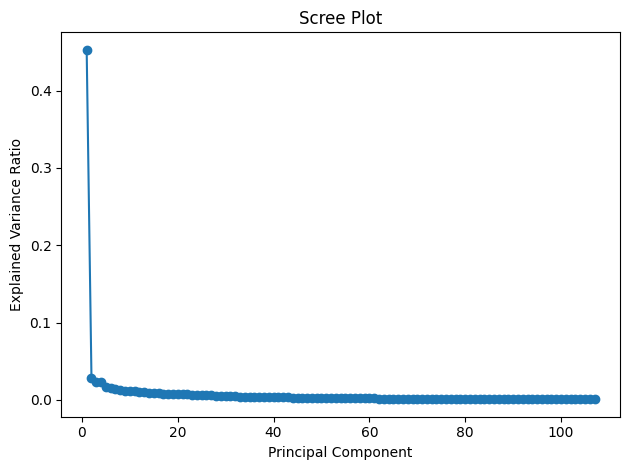

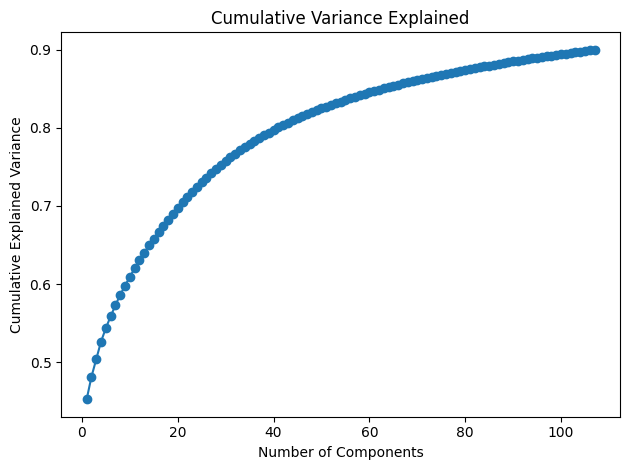

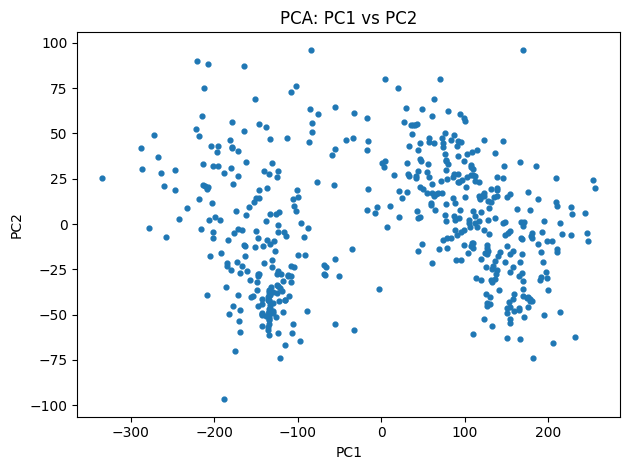

In [64]:
plt.figure()
plt.plot(var_df["PC"].str.replace("PC", "").astype(int), var_df["explained"], marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_scree.png", dpi=300)

plt.figure()
plt.plot(var_df["PC"].str.replace("PC", "").astype(int), var_df["cumulative"], marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Explained")
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_cumulative.png", dpi=300)

if pca_df.shape[1] >= 2:
    plt.figure()
    plt.scatter(pca_df["PC1"], pca_df["PC2"], s=12)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA: PC1 vs PC2")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "pca_pc1_pc2.png", dpi=300)

In [65]:
results = {}

def add_result(name, k, labels):
    uniq = set(labels)
    if len(uniq) < 2 or len(uniq) == len(labels):
        return  # trivial
    sil = silhouette_score(pca_df, labels)
    results[(name, k)] = (labels, sil)

In [66]:
for method, cls in [("kmeans", KMeans), ("ward", AgglomerativeClustering), ("gmm", GaussianMixture)]:
    for k in range(2, 11):
        if method == "kmeans":
            model = cls(n_clusters=k, n_init='auto', random_state=0)
            lbl = model.fit_predict(pca_df)
        elif method == "ward":
            model = cls(n_clusters=k, linkage="ward")
            lbl = model.fit_predict(pca_df)
        else:  # gmm
            model = cls(n_components=k, covariance_type="full", random_state=0)
            lbl = model.fit_predict(pca_df)
        add_result(method, k, lbl)

In [67]:
for eps in [1.0, 2.0, 3.0, 5.0]:
    db = DBSCAN(eps=eps, min_samples=5).fit(pca_df)
    lbl = db.labels_
    if (-1 in lbl):
        mask = lbl != -1
        if len(set(lbl[mask])) >= 2:
            add_result(f"dbscan_eps{eps}", None, lbl)
    else:
        add_result(f"dbscan_eps{eps}", None, lbl)

In [68]:
opt = OPTICS(min_samples=5, xi=0.05, min_cluster_size=10).fit(pca_df)
lbl_opt = opt.labels_
if (-1 in lbl_opt):
    mask = lbl_opt != -1
    if len(set(lbl_opt[mask])) >= 2:
        add_result("optics", None, lbl_opt)
else:
    add_result("optics", None, lbl_opt)

In [69]:
best_key, (best_lbl, best_sil) = max(results.items(), key=lambda x: x[1][1])

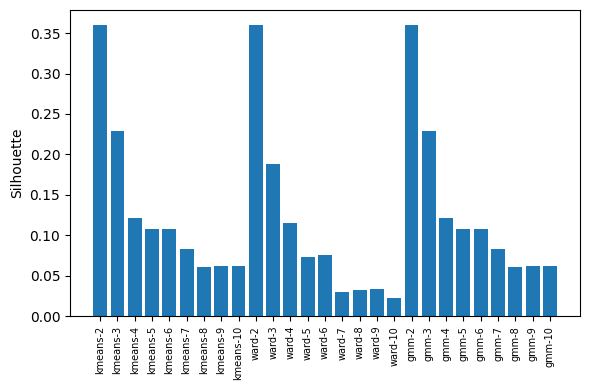

In [70]:
Path(OUT_DIR).mkdir(exist_ok=True)

pca_df.to_csv(OUT_DIR / "luad_pca_scores.csv")
var_df.to_csv(OUT_DIR / "luad_pca_variance.csv", index=False)
clusters = pd.Series(best_lbl, index=pca_df.index, name="cluster")
clusters.to_csv(OUT_DIR / "luad_clusters.csv")

# silhouette comparison plot
plt.figure(figsize=(6, 4))
plt.bar([f"{k[0]}-{k[1] if k[1] else ''}" for k in results], [v[1] for v in results.values()])
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Silhouette")
plt.tight_layout()
plt.savefig(OUT_DIR / "silhouette_methods.png", dpi=300)

Finished. Best clustering = ('kmeans', 2) (silhouette 0.361). Outputs in ./processed/


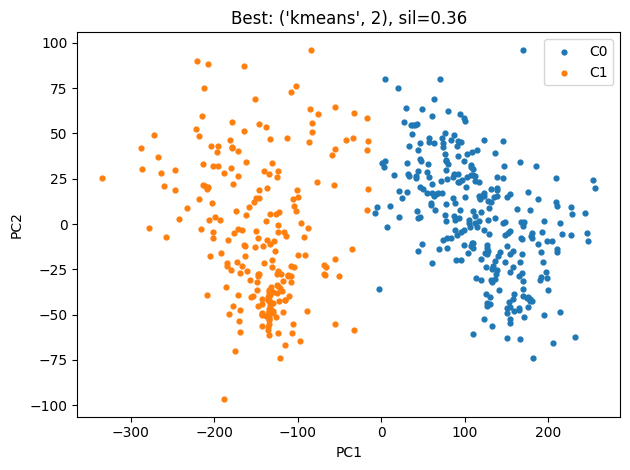

In [71]:
if pca_df.shape[1] >= 2:
    plt.figure()
    for cl in sorted(set(best_lbl)):
        mask = clusters == cl
        plt.scatter(pca_df.loc[mask, "PC1"], pca_df.loc[mask, "PC2"], s=12, label=f"C{cl}")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"Best: {best_key}, sil={best_sil:.2f}"); plt.legend(); plt.tight_layout()
    plt.savefig(OUT_DIR / "pca_best_clusters.png", dpi=300)

print(f"Finished. Best clustering = {best_key} (silhouette {best_sil:.3f}). Outputs in ./processed/")

In [73]:
# Entrez ➜ HUGO сопоставление (работает без ошибок)
mut = pd.read_csv("processed/luad_mut_flt.csv", index_col=0)
clu = pd.read_csv("processed/luad_clusters.csv", index_col=0).squeeze("columns")
url = "https://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz"
gene_map = (
    pd.read_csv(
        url,
        sep="\t",
        compression="gzip",
        comment="#",
        header=None,
        usecols=[1, 2],          # 1 = GeneID, 2 = Symbol
        names=["GeneID", "Symbol"]
    )
    .set_index("GeneID")["Symbol"]
)

def top_genes(cluster_id, n=10):
    mask = clusters == cluster_id
    freq = mut.loc[:, mask].mean(axis=1).sort_values(ascending=False).head(n)
    freq.index = freq.index.map(lambda eid: f"{gene_map.get(eid, '?')} ({eid})")
    return freq

for c in sorted(clusters.unique()):
    print(f"\nCluster {c} top genes:")
    print(top_genes(c))


Cluster 0 top genes:
Entrez_Gene_Id
TP53 (7157)       0.565217
TTN (7273)        0.554348
MUC16 (94025)     0.463768
CSMD3 (114788)    0.463768
RYR2 (6262)       0.398551
USH2A (7399)      0.387681
ZFHX4 (79776)     0.373188
LRP1B (53353)     0.369565
KRAS (3845)       0.297101
XIRP2 (129446)    0.271739
dtype: float64

Cluster 1 top genes:
Entrez_Gene_Id
TP53 (7157)       0.386047
MUC16 (94025)     0.306977
TTN (7273)        0.279070
CSMD3 (114788)    0.274419
RYR2 (6262)       0.269767
KRAS (3845)       0.255814
LRP1B (53353)     0.251163
ZFHX4 (79776)     0.213953
FLG (2312)        0.186047
USH2A (7399)      0.186047
dtype: float64


Кривые Kaplan–Meier сохранены: processed/km_clusters.png


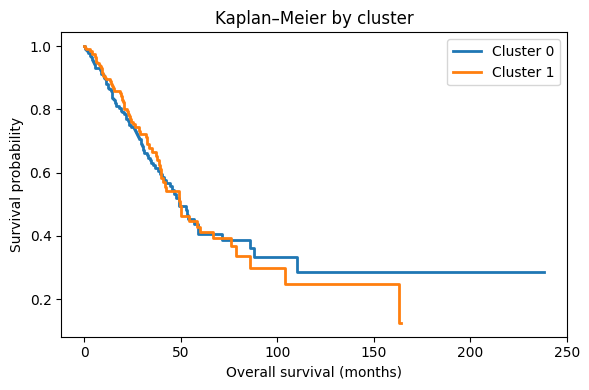

In [74]:
# 2) clinical_sample — здесь есть SAMPLE_ID → PATIENT_ID
samp = pd.read_csv(DATA_DIR / "data_clinical_sample.txt", sep="\t", comment="#")
samp = samp.set_index("SAMPLE_ID")
samp["cluster"] = clu            # добавляем метку по SAMPLE_ID

# 3) оставляем только те строки, где кластер известен
samp = samp.dropna(subset=["cluster"])
samp["cluster"] = samp["cluster"].astype(int)

# 4) clinical_patient
pat = pd.read_csv(DATA_DIR / "data_clinical_patient.txt", sep="\t", comment="#")
pat = pat.set_index("PATIENT_ID")

# 5) переносим кластер с sample на patient
#    (если у пациента >1 образца, берём первый ― можно заменить на моду)
pat["cluster"] = (
    samp.groupby("PATIENT_ID")["cluster"]
        .first()                 # или .mode().iloc[0]
)

pat = pat.dropna(subset=["cluster"])
pat["cluster"] = pat["cluster"].astype(int)

# ---------- survival columns ----------
time  = pat["OS_MONTHS"]
event = pat["OS_STATUS"].str.startswith("1").astype(int)

# убрать нули / NaN
valid = time.notna() & (time > 0)
pat   = pat[valid]; time = time[valid]; event = event[valid]

# ---------- Kaplan–Meier ----------
plt.figure(figsize=(6,4))
ax = plt.gca()

for c in sorted(pat["cluster"].unique()):
    mask = pat["cluster"] == c
    km = KaplanMeierFitter()
    km.fit(time[mask], event[mask], label=f"Cluster {c}")
    km.plot(ax=ax, ci_show=False, linewidth=2)

ax.set_xlabel("Overall survival (months)")
ax.set_ylabel("Survival probability")
ax.set_title("Kaplan–Meier by cluster")
plt.tight_layout()
plt.savefig(OUT_DIR / "km_clusters.png", dpi=300)

print("Кривые Kaplan–Meier сохранены: processed/km_clusters.png")


In [75]:
clusters = pat["cluster"].unique()

c0, c1 = clusters
res = statistics.logrank_test(
    time[pat.cluster == c0],
    time[pat.cluster == c1],
    event_observed_A=event[pat.cluster == c0],
    event_observed_B=event[pat.cluster == c1],
)
p_val = res.p_value
print(f"Log‑rank p‑value (C{c0} vs C{c1}) = {p_val:.4f}")

Log‑rank p‑value (C0 vs C1) = 0.8399
